In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from dataset import DIV2KDataset
from model_swinir import SwinIR

# Fix for potential OpenMP runtime conflict on Windows
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

c:\Users\jan\miniconda3\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset downloaded to: C:\Users\jan\.cache\kagglehub\datasets\takihasan\div2k-dataset-for-super-resolution\versions\1


In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Hyperparameters
SCALE = 4
BATCH_SIZE = 4
NUM_EPOCHS = 1
LEARNING_RATE = 1e-4
CROP_SIZE = 192 # HR crop size (LR will be 48)

# Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Datasets
# dataset.py handles the download and path automatically
train_dataset = DIV2KDataset(scale=SCALE, mode='train', crop_size=CROP_SIZE, transform=transform)
valid_dataset = DIV2KDataset(scale=SCALE, mode='valid', crop_size=None, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

print(f"Train loader batches: {len(train_loader)}")
print(f"Valid loader batches: {len(valid_loader)}")

Train loader batches: 200
Valid loader batches: 100


In [4]:
# Model setup
# Using a lightweight configuration for demonstration
model = SwinIR(
    upscale=SCALE,
    in_chans=3,
    img_size=CROP_SIZE // SCALE,
    window_size=8,
    img_range=1.,
    depths=[4, 4, 4, 4], 
    embed_dim=60, 
    num_heads=[6, 6, 6, 6],
    mlp_ratio=2,
    upsampler='pixelshuffle',
    resi_connection='1conv'
).to(device)

# Loss and Optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

c:\Users\jan\miniconda3\envs\torch\Lib\site-packages\torch\functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4319.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
# Training Loop
print("Starting training...")
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for i, (lr_imgs, hr_imgs) in enumerate(train_loader):
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(lr_imgs)
        loss = criterion(outputs, hr_imgs)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if (i+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
            
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] Average Loss: {running_loss / len(train_loader):.4f}")

print("Training finished.")

Starting training...
Epoch [1/1], Step [10/134], Loss: 0.1241
Epoch [1/1], Step [10/134], Loss: 0.1241
Epoch [1/1], Step [20/134], Loss: 0.1290
Epoch [1/1], Step [20/134], Loss: 0.1290
Epoch [1/1], Step [30/134], Loss: 0.0825
Epoch [1/1], Step [30/134], Loss: 0.0825
Epoch [1/1], Step [40/134], Loss: 0.0944
Epoch [1/1], Step [40/134], Loss: 0.0944
Epoch [1/1], Step [50/134], Loss: 0.0868
Epoch [1/1], Step [50/134], Loss: 0.0868
Epoch [1/1], Step [60/134], Loss: 0.0796
Epoch [1/1], Step [60/134], Loss: 0.0796
Epoch [1/1], Step [70/134], Loss: 0.0705
Epoch [1/1], Step [70/134], Loss: 0.0705
Epoch [1/1], Step [80/134], Loss: 0.0563
Epoch [1/1], Step [80/134], Loss: 0.0563
Epoch [1/1], Step [90/134], Loss: 0.0553
Epoch [1/1], Step [90/134], Loss: 0.0553
Epoch [1/1], Step [100/134], Loss: 0.0518
Epoch [1/1], Step [100/134], Loss: 0.0518
Epoch [1/1], Step [110/134], Loss: 0.0615
Epoch [1/1], Step [110/134], Loss: 0.0615
Epoch [1/1], Step [120/134], Loss: 0.0892
Epoch [1/1], Step [120/134], Lo

In [ ]:
# Save the model weights
torch.save(model.state_dict(), 'swinir_model_other.pth')
print("Model saved to swinir_model.pth")

Model saved to swinir_model.pth


In [5]:
# Instantiate a new model and load weights
loaded_model = SwinIR(
    upscale=SCALE,
    in_chans=3,
    img_size=CROP_SIZE // SCALE,
    window_size=8,
    img_range=1.,
    depths=[4, 4, 4, 4], 
    embed_dim=60, 
    num_heads=[6, 6, 6, 6],
    mlp_ratio=2,
    upsampler='pixelshuffle',
    resi_connection='1conv'
).to(device)

if os.path.exists('swinir_model.pth'):
    loaded_model.load_state_dict(torch.load('swinir_model.pth'))
    loaded_model.eval()
    print("Model loaded from swinir_model.pth")
else:
    print("Model file not found.")

Model loaded from swinir_model.pth


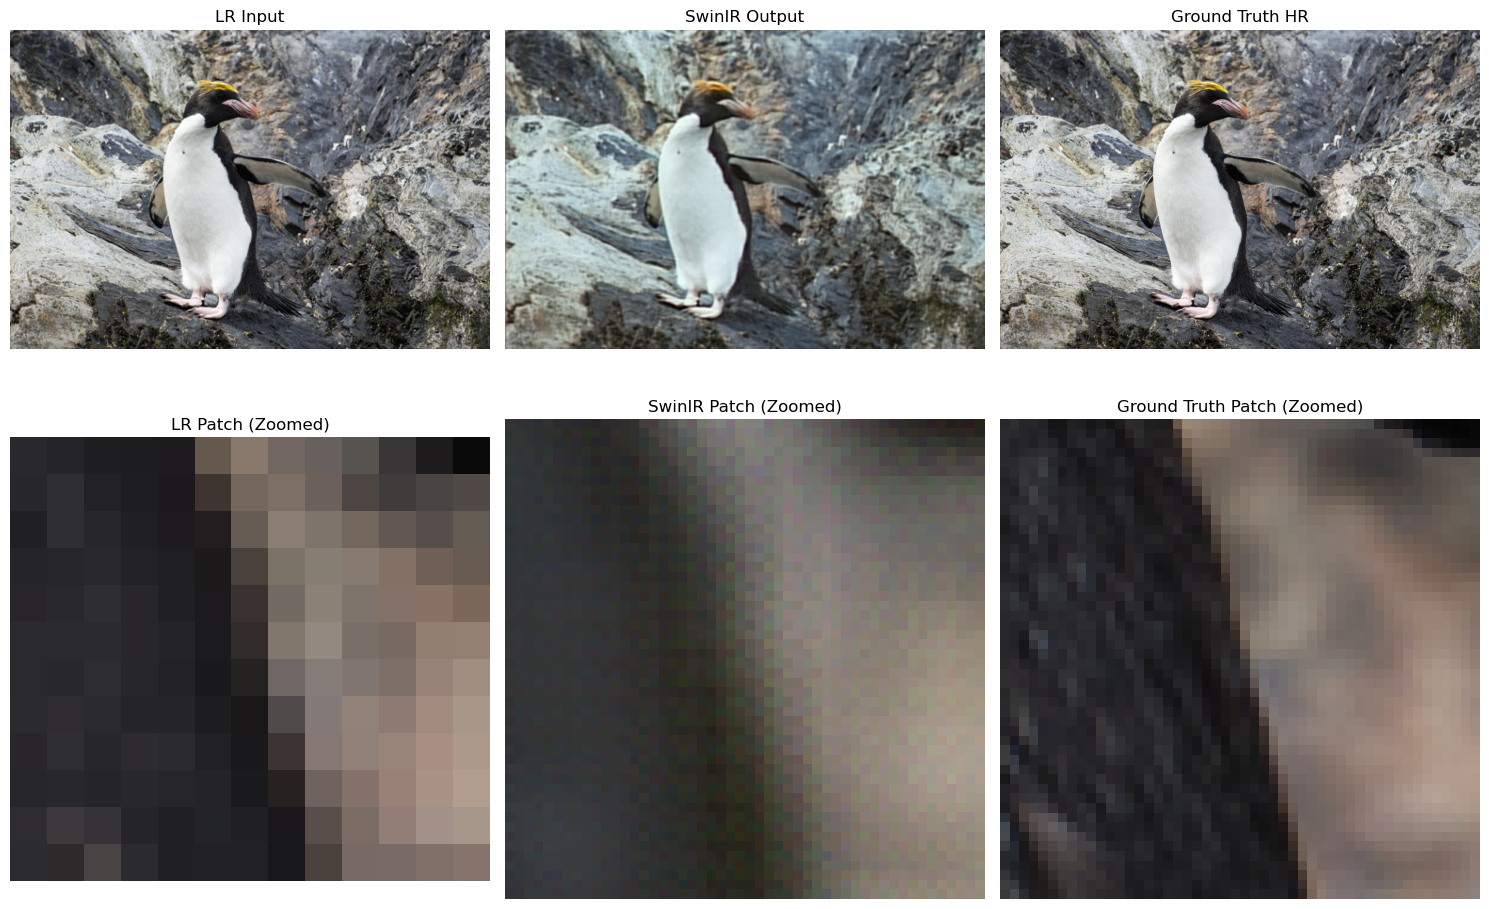

In [7]:
# Visualize results
#model = model
model = loaded_model
model.eval()
with torch.no_grad():
    # Get a batch from validation loader
    val_lr, val_hr = next(iter(valid_loader))
    val_lr = val_lr.to(device)
    
    # Predict
    val_output = model(val_lr)
    
    # Move to CPU for plotting
    val_lr = val_lr.cpu()
    val_hr = val_hr.cpu()
    val_output = val_output.cpu()
    
    # Define zoom parameters (center crop)
    h, w = val_hr.shape[2], val_hr.shape[3]
    cx, cy = h // 2, w // 2
    crop_size = 50  # Size of the crop in HR pixels
    
    # Calculate crop coordinates
    hr_y1, hr_y2 = cx - crop_size // 2, cx + crop_size // 2
    hr_x1, hr_x2 = cy - crop_size // 2, cy + crop_size // 2
    
    # LR coordinates (scale factor 4)
    lr_y1, lr_y2 = hr_y1 // 4, hr_y2 // 4
    lr_x1, lr_x2 = hr_x1 // 4, hr_x2 // 4

    # Plot
    plt.figure(figsize=(15, 10))
    
    # Full images
    plt.subplot(2, 3, 1)
    plt.imshow(val_lr[0].permute(1, 2, 0).numpy())
    plt.title("LR Input")
    plt.axis('off')
    
    plt.subplot(2, 3, 2)
    plt.imshow(val_output[0].permute(1, 2, 0).clamp(0, 1).numpy())
    plt.title("SwinIR Output")
    plt.axis('off')
    
    plt.subplot(2, 3, 3)
    plt.imshow(val_hr[0].permute(1, 2, 0).numpy())
    plt.title("Ground Truth HR")
    plt.axis('off')

    # Zoomed patches
    plt.subplot(2, 3, 4)
    # Display LR patch
    plt.imshow(val_lr[0, :, lr_y1:lr_y2, lr_x1:lr_x2].permute(1, 2, 0).numpy())
    plt.title("LR Patch (Zoomed)")
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(val_output[0, :, hr_y1:hr_y2, hr_x1:hr_x2].permute(1, 2, 0).clamp(0, 1).numpy())
    plt.title("SwinIR Patch (Zoomed)")
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(val_hr[0, :, hr_y1:hr_y2, hr_x1:hr_x2].permute(1, 2, 0).numpy())
    plt.title("Ground Truth Patch (Zoomed)")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()